### This notebook is dedicated to investigating different methods applying TWSA from GRACE and GRACE-FO to obtain the time derivatives of TWSA. The results will be used in monitoring extreme events such as floods and droughts in the Greater Horn of Africa region.
Author: S. Karimi Feb 2024 (s.karimi@utwente.nl)

# Read data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import xarray as xr 
import shxarray
import numpy as np
import matplotlib.pyplot as plt

from common.config import read_config

In [3]:
conf=read_config()
datadir=conf["dataroot"]

In [4]:
tws_sh=os.path.join(datadir,conf["nctws"])
dtws=xr.open_dataset(tws_sh)
dtws=dtws.sh.build_nmindex()
display(dtws)
ncbasins=os.path.join(datadir,conf["ncbasin"])
dsbasins_sh=xr.open_dataset(ncbasins).sh.truncate(nmax=96)
dsbasins_sh=dsbasins_sh.sh.build_nmindex()

<xarray.Dataset> Size: 18MB
Dimensions:  (time: 230, nm: 9408)
Coordinates:
  * time     (time) datetime64[ns] 2kB 2002-05-15T12:00:00 ... 2024-04-15T12:...
  * nm       (nm) object 75kB MultiIndex
  * n        (nm) int64 75kB 1 1 1 2 2 2 2 2 3 3 ... 96 96 96 96 96 96 96 96 96
  * m        (nm) int64 75kB 0 1 -1 0 1 -1 2 -2 ... 93 -93 94 -94 95 -95 96 -96
Data variables:
    tws      (time, nm) float64 17MB ...

In [85]:
shxengine='shtns'
dsbasinav = dtws.tws.sh.basinav(dsbasins_sh.basins, filtername="Gauss300", leakage_corr="scale", engine=shxengine).compute()

# Time derivatives of TWS anomalies

# Bspline smoothing

We create an approximation of the TWSA time series from GRCAE/GRACE-FO using the Bspline smoothing method. The advantage of this method is that it does not require passing from all data points of GRACE and GRACE_FO observations, which are noisy.

The approximated version is indicated for GRACE-FO time series.

In [7]:
from scipy.interpolate import splrep, BSpline # source: https://docs.scipy.org/doc/scipy/tutorial/interpolate/smoothing_splines.html

In [8]:
def twsrate(dsbasinav,timestps,deg,smoothinglvl):
    
    tck=splrep(timestps,dsbasinav,k=deg,s=smoothinglvl)
    bs=BSpline(*tck)
    bs_dr=bs.derivative()
    dydt=bs_dr(timestps)
    return dydt

In [75]:
timestps=(dsbasinav.time-dsbasinav.time[0])/np.timedelta64(1,"s")
deg=3
smoothinglvl=0.001*len(timestps)

bsdsdt=xr.apply_ufunc(twsrate,dsbasinav,dsbasinav.time,deg,smoothinglvl,input_core_dims=[["time"],["time"],[],[]],output_core_dims=[["time"]],vectorize=True)

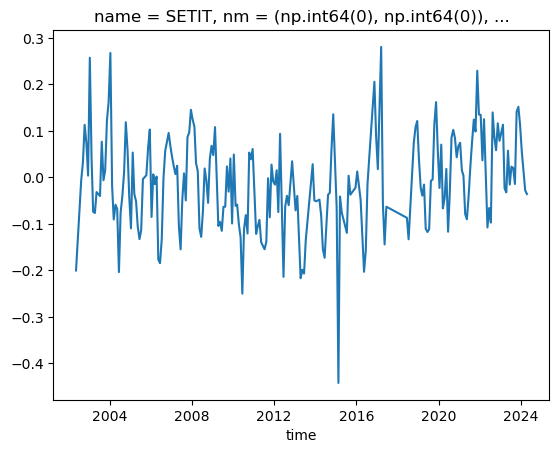

In [76]:
dsbasinav.sel(name="SETIT").plot()

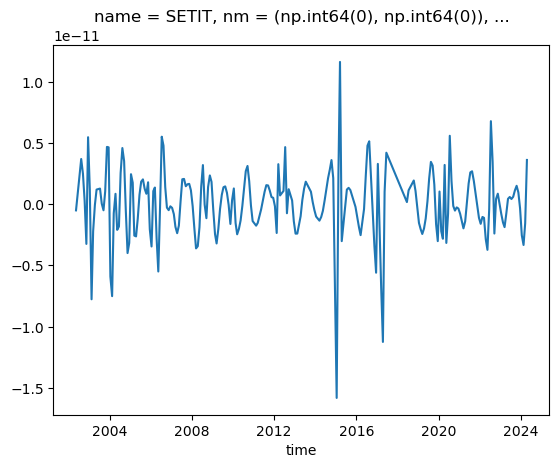

In [77]:
N=dsbasinav.time.dt.days_in_month
bsdsdt_month = bsdsdt*N*3600
bsdsdt_month.sel(name="SETIT").plot()

# Comparing with other methods

In [86]:
def tws_time_derivatives(dsbasinav):
    
    dt=dsbasinav.time.diff("time",label='upper')/np.timedelta64(1,"s")
    deltatws=dsbasinav.diff("time",label='upper')
    dsdt_backward=deltatws/dt
    dsdt_backward = dsdt_backward.reindex(time=dsbasinav.time)

    dsdt_derivatives=dsbasinav.differentiate(coord="time",edge_order=1,datetime_unit="s")

    dt_center=(dsbasinav.time.shift(time=-1)-dsbasinav.time.shift(time=1))/np.timedelta64(1,"s")
    dsdt_central=(dsbasinav.shift(time=-1)-dsbasinav.shift(time=1))/dt_center

    return dsdt_backward,dsdt_derivatives,dsdt_central
    

In [87]:
dsdt_backward,dsdt_derivatives,dsdt_central=tws_time_derivatives(dsbasinav)

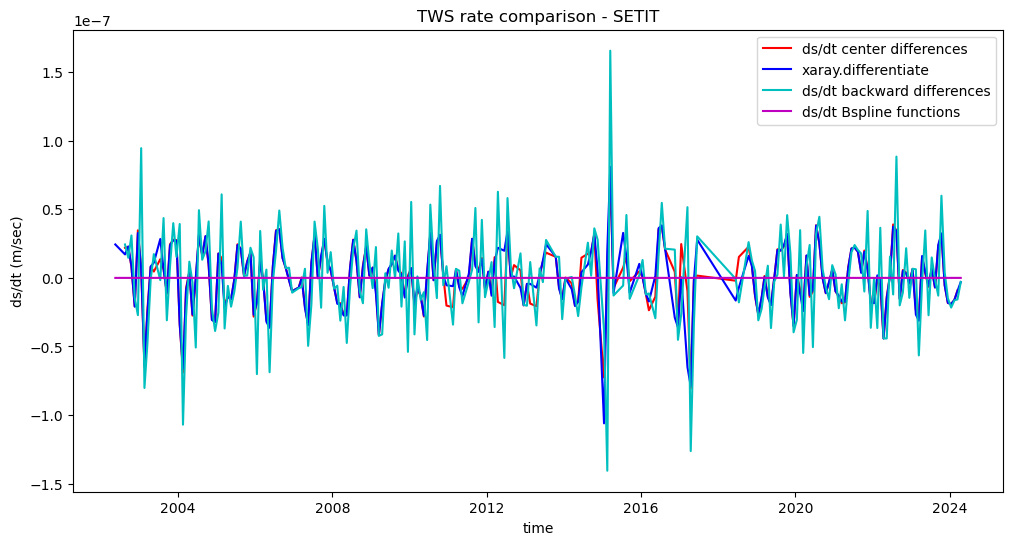

In [88]:
plt.figure(figsize=(12,6))

basinname="SETIT"

plt.plot(dsdt_central.time,dsdt_central.sel(name=basinname),label="ds/dt center differences",color="r")
plt.plot(dsdt_derivatives.time,dsdt_derivatives.sel(name=basinname),label="xaray.differentiate",color="b")
plt.plot(dsdt_backward.time,dsdt_backward.sel(name=basinname),label="ds/dt backward differences",color="c")
plt.plot(bsdsdt_month.time,bsdsdt_month.sel(name=basinname),label="ds/dt Bspline functions",color="m")

#name = dsbasinav.coords["name"].sel(name="SETIT").values
plt.title(f"TWS rate comparison - {basinname}")
plt.ylabel("ds/dt (m/sec)")
plt.xlabel("time")
plt.legend()


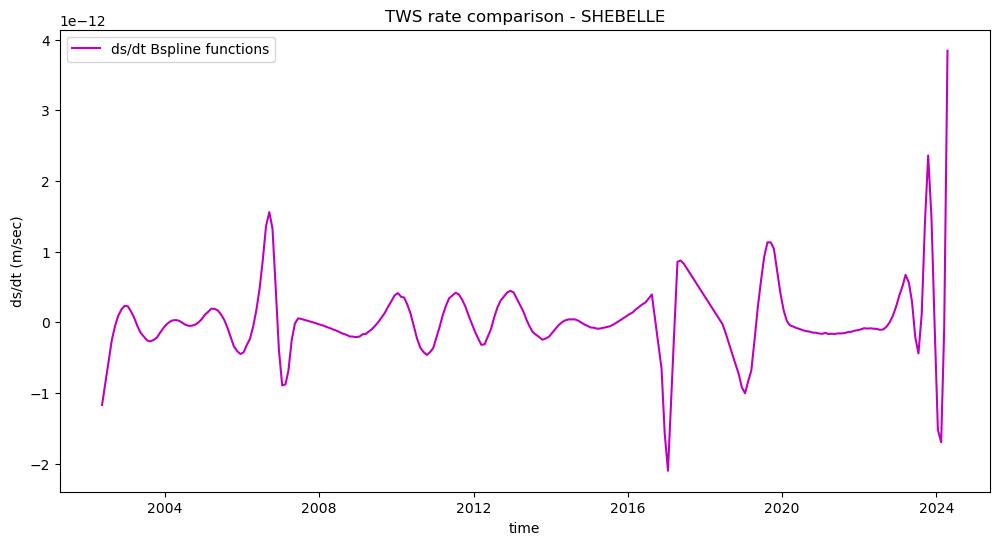

In [89]:
plt.figure(figsize=(12,6))

basinname="SHEBELLE"

plt.plot(bsdsdt_month.time,bsdsdt_month.sel(name=basinname),label="ds/dt Bspline functions",color="m")

#name = dsbasinav.coords["name"].sel(name="SETIT").values
plt.title(f"TWS rate comparison - {basinname}")
plt.ylabel("ds/dt (m/sec)")
plt.xlabel("time")
plt.legend()

# Comparing three methods 

# Conclusion

The Centered method results in a smoother rate than the backward method. However, both backwards and centered differences methods do not indicate the effect of the significant increase in TWSA from 2019 to 2021 in the TWSA time series obtained from GRACE-FO observations. This limitation can be due to high noise levels present in GRACE/GRACE-FO observations after filtering, which indicates that a higher level of smoothing is still required. 

In contrast, the Bspline method yields a smoother, more robust, and less noisy signal.

As a result, it is recommended to approximate the TWSA time series using cubic B-spline functions.